# Extract data from EBI Complex Portal

Purpose of this notebook is to extract and format ComplexPortal data for subsequent model annotation. Additionally, extract data for reconcilliation of model complexes and complex stoichiometry.

## Notebook Requirements:
*  Model genes **must** have at least the following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Possible keys include:
    * `"complexportal"`
    * `"uniprot"`
*  Note: Requires internet connection to download information from [Complex Portal](https://www.ebi.ac.uk/complexportal/home).



### Citations
Meldal BHM, Bye-A-Jee H, Gajdoš L, Hammerová Z, Horácková A, Melicher F, Perfetto L, Pokorný D, Lopez MR, Türková A, Wong ED, Xie Z, Casanova EB, Del-Toro N, Koch M, Porras P, Hermjakob H, Orchard S. Complex Portal 2018: extended content and enhanced visualization tools for macromolecular complexes. Nucleic Acids Res. 2019 Jan 8;47(D1):D550-D558. doi: 10.1093/nar/gky1001. PMID: 30357405; PMCID: PMC6323931.

## Setup
### Import packages

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    DATABASE_PATH,
    CURATION_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    PROCESSED_PATH,
    GEM_NAME,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    show_versions,
    check_version,
    split_string,
    build_string,
    check_database_version_online,
    explode_column,
)
from rbc_gem_utils.database.uniprot import UNIPROT_ISOFORM_ID_RE
from rbc_gem_utils.database.complexportal import (
    get_version_ComplexPortal,
    COMPLEXPORTAL_PATH,
    COMPLEXPORTAL_DB_TAG,
    COMPLEXPORTAL_VERSION_EXPECTED,
    COMPLEXPORTAL_URL,
    parse_complex_participants,
)

from rbc_gem_utils.util import ensure_iterable

## Check Complex Portal version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected Complex Portal version: 2-Feb-2024
* According to [Complex Portal](https://www.ebi.ac.uk/complexportal/download), database is released monthly. 
* All files are available from the ftp site  and will be updated as we add new complexes with every data release.
* Last modified date on file: **2024-02-14**.

In [2]:
if not check_database_version_online(COMPLEXPORTAL_DB_TAG):
    warn(
        "Online version of database has been updated since the last time notebook was used."
    )

taxomony_int = 9606
version = get_version_ComplexPortal(taxomony_int)
if check_version(version, COMPLEXPORTAL_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}{COMPLEXPORTAL_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"

Current and expected versions match.


#### Download new files and update database
If an argument is not provided (`arg=None`), its default value for the repository used. 

In [3]:
download = False
if download:
    pd.read_csv(
        f"{COMPLEXPORTAL_URL}/{taxomony_int}.tsv",
        sep="\t",
    ).to_csv(f"{database_dirpath}/{taxomony_int}.tsv", sep="\t", index=False)

## Load RBC-GEM model

In [4]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,149e82f50
Number of metabolites,2057
Number of reactions,3030
Number of genes,779
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [5]:
annotation_type = "genes"
annotation_cols = ["uniprot", "complexportal"]
mapping_key = "complexportal"

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)

df_model_mappings

genes             91
uniprot           91
complexportal    360
dtype: int64


,genes,uniprot,complexportal
0,ACTB,P60709,CPX-978
1,ACTB,P60709,CPX-1220
2,ACTB,P60709,CPX-1225
3,ACTB,P60709,CPX-4207
4,ACTB,P60709,CPX-1207
...,...,...,...
580,VCP,P55072,CPX-8095
581,VCP,P55072,CPX-262
582,VCP,P55072,CPX-137
583,VCP,P55072,CPX-8133


## Set notebook options

In [6]:
compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True
db_tag = COMPLEXPORTAL_DB_TAG

## Load ComplexPortal data

In [7]:
df_complexportal_data = pd.read_csv(
    f"{database_dirpath}/{taxomony_int}.tsv",
    sep="\t",
)
df_complexportal_data

,#Complex ac,Recommended name,Aliases for complex,Taxonomy identifier,Identifiers (and stoichiometry) of molecules in complex,Evidence Code,Experimental evidence,Go Annotations,Cross references,Description,Complex properties,Complex assembly,Ligand,Disease,Agonist,Antagonist,Comment,Source,Expanded participant list
0,CPX-1,SMAD2-SMAD3-SMAD4 complex,SMAD2/SMAD3/SMAD4 transcription factor complex,9606,P84022(1)|Q13485(1)|Q15796(1),ECO:0005547(biological system reconstruction e...,-,GO:0071144(heteromeric SMAD protein complex)|G...,pubmed:16322555(see-also)|complex portal:CPX-1...,A transcription factor complex which binds to ...,Preferential formation of the regulatory R-Sma...,Heterotrimer,-,-,-,-,-,"psi-mi:""MI:0469""(IntAct)",P84022(1)|Q13485(1)|Q15796(1)
1,CPX-8,"bZIP transcription factor complex, ATF4-CREB1",-,9606,P16220(1)|P18848(1),ECO:0005544(biological system reconstruction e...,-,GO:0000977(RNA polymerase II transcription reg...,pubmed:23661758(see-also)|pubmed:28186491(see-...,Transcription factor complex that binds the cA...,-,Heterodimer,-,-,-,-,-,"psi-mi:""MI:0469""(IntAct)",P16220(1)|P18848(1)
2,CPX-9,"bZIP transcription factor complex, ATF1-ATF4",ATF4-ATF1 transcription factor complex,9606,P18846(1)|P18848(1),ECO:0005544(biological system reconstruction e...,-,GO:0005634(nucleus)|GO:0000977(RNA polymerase ...,pubmed:23661758(see-also)|pubmed:28186491(see-...,Transcription factor complex which binds to a ...,Dimerization is mediated by the basic leucine-...,Heterodimer,-,-,-,-,-,"psi-mi:""MI:0469""(IntAct)",P18846(1)|P18848(1)
3,CPX-11,SMAD2 homotrimer,-,9606,Q15796(3),ECO:0000353(physical interaction evidence used...,intact:EBI-25772094,GO:0071142(homomeric SMAD protein complex),pubmed:11779503(see-also)|pubmed:16322555(see-...,"In the absence of Smad4, R-Smad phosphorylatio...",The R-Smad homotrimer is stabilized by the int...,Homotrimer,-,-,-,-,-,"psi-mi:""MI:0469""(IntAct)",Q15796(3)
4,CPX-12,SMAD3 homotrimer,-,9606,P84022(3),ECO:0005546(biological system reconstruction e...,-,GO:0071142(homomeric SMAD protein complex),wwpdb:1khx(identity)|pubmed:16322555(see-also)...,"In the absence of Smad4, R-Smad phosphorylatio...",The R-Smad homotrimer is stabilized by the int...,Homotrimer,-,-,-,-,-,"psi-mi:""MI:0469""(IntAct)",P84022(3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,CPX-3288,HSP90A-CDC37 chaperone complex,-,9606,P07900(2)|Q16543(2),ECO:0000353(physical interaction evidence used...,intact:EBI-9371424,GO:1990565(HSP90-CDC37 chaperone complex)|GO:0...,pubmed:19387550(see-also)|wwpdb:2k5b(identity)...,A protein kinase chaperone complex required fo...,CDC37 binds its target proteins via its N-term...,Heterotetramer,-,-,-,-,-,"psi-mi:""MI:0469""(IntAct)",P07900(2)|Q16543(2)
2046,CPX-3290,Interleukin-23 complex,IL-23 complex|p19p40 complex|IL23 complex|p19-...,9606,P29460-PRO_0000010930(1)|Q9NPF7-PRO_0000259488(1),ECO:0000353(physical interaction evidence used...,intact:EBI-9633865,GO:0006955(immune response)|GO:0032729(positiv...,pubmed:25516297(see-also)|reactome:R-HSA-44721...,Cytokine complex that activates and stimulates...,-,Heterodimer,-,Psoriasis [EFO:0000676]: a common genetically ...,-,-,-,"psi-mi:""MI:0469""(IntAct)",P29460-PRO_0000010930(1)|Q9NPF7-PRO_0000259488(1)
2047,CPX-3291,"SCF E3 ubiquitin ligase complex, FBXL3 variant",CRL1-FBXL3 complex|SCF-FBXL3 complex,9606,P62877(1)|P63208(1)|Q13616(1)|Q9UKT7(1),ECO:0005546(biological system reconstruction e...,-,GO:0042752(regulation of circadian rhythm)|GO:...,wwpdb:1LDJ(subset)|pubmed:17463251(see-also)|c...,E3 ubiquitin ligase which catalyzes the transf...,The cullin protein (CUL1) acts as an assembly ...,Heterotetramer,-,-,-,-,-,"psi-mi:""-""(ceitec)",P62877(1)|P63208(1)|Q13616(1)|Q9UKT7(1)
2048,CPX-3292,"SCF E3 ubiquitin ligase complex, FBXL2 variant",CRL1-FBXL2 complex|SCF-FBXL2 complex,9606,P62877(1)|P63208(1)|Q13616(1)|Q9UKC9(1),ECO:0005546(biological system reconstruction e...,-,GO:0050727(regulation of i

## Map to model genes


In [8]:
col = "Expanded participant list"
df = parse_complex_participants(
    df_complexportal_data.set_index("#Complex ac")[col]
).reset_index(drop=False)
df = df.rename({"#Complex ac": "complexportal"}, axis=1)

df["uniprot"] = df["participants"].apply(lambda x: ensure_iterable(x.split("-")[0]))
df = df.explode("uniprot")

if mapping_key == "complexportal":
    df = df[df["complexportal"].isin(df_model_mappings["complexportal"].values)]
else:
    df["participants"] = df["participants"].apply(lambda x: x.split("-")[0])
    df = df[df["participants"].isin(df_model_mappings[mapping_key].values)]
df_complex_participants = df.copy()
df_complex_participants = df_complex_participants.sort_values(
    ["complexportal", "uniprot"], ascending=[True, True]
)
df_complex_participants = df_complex_participants.reset_index(drop=True)
print(df_complex_participants.nunique())
df_complex_participants

complexportal                 360
participants_stoichiometry    492
participants                  450
stoichiometry                   7
uniprot                       446
dtype: int64


,complexportal,participants_stoichiometry,participants,stoichiometry,uniprot
0,CPX-1017,P04839(0),P04839,0,P04839
1,CPX-1017,P13498(0),P13498,0,P13498
2,CPX-1017,P14598(0),P14598,0,P14598
3,CPX-1017,P19878(0),P19878,0,P19878
4,CPX-1017,P63000(0),P63000,0,P63000
...,...,...,...,...,...
1579,CPX-978,Q9Y4A5(0),Q9Y4A5,0,Q9Y4A5
1580,CPX-99,O15169(1),O15169,1,O15169
1581,CPX-99,O95996(0),O95996,0,O95996
1582,CPX-99,P48729(0),P48729,0,P48729


## Format ComplexPortal information for annotation files

In [9]:
df_model_complex_annotations = df_complexportal_data[
    df_complexportal_data["#Complex ac"].isin(df_complex_participants["complexportal"])
].copy()
df_model_complex_annotations = df_model_complex_annotations.reset_index(drop=True)
rename_mapping = {
    "#Complex ac": "complexportal",
    "Recommended name": "complexportal.name",
    "Aliases for complex": "complexportal.alias",
    "Identifiers (and stoichiometry) of molecules in complex": "complexportal.stoichiometry.all",
    "Experimental evidence": "complexportal.evidence",
    "Cross references": "complexportal.cross_references",
    "Description": "complexportal.description",
    "Complex properties": "complexportal.properties",
    "Complex assembly": "complexportal.assembly",
    "Ligand": "complexportal.ligand",
    "Disease": "complexportal.disease",
    "Agonist": "complexportal.agonist",
    "Antagonist": "complexportal.antagonist",
    "Comment": "complexportal.comment",
    "Source": "complexportal.source",
    "Taxonomy identifier": "taxomony",
    "Evidence Code": "eco",
    "Go Annotations": "go",
    "Expanded participant list": "uniprot",
}
df_model_complex_annotations = df_model_complex_annotations.replace("-", "")
df_model_complex_annotations = df_model_complex_annotations.loc[
    :, list(rename_mapping)
].rename(rename_mapping, axis=1)
df_model_complex_annotations
for key in df_model_complex_annotations.columns:
    df_model_complex_annotations[key] = df_model_complex_annotations[key].apply(
        lambda x: build_string(x.split("|")) if isinstance(x, str) else x
    )

    if key == "complexportal.cross_references":
        for subkey in {"reactome", "complex portal", "pubmed", "intenz"}:
            df_model_complex_annotations[subkey] = df_model_complex_annotations[
                key
            ].apply(
                lambda x: build_string(
                    [
                        s.split("(")[0].replace(" ", "").replace(f"{subkey}:", "")
                        for s in x.split(";")
                        if s.startswith(subkey)
                    ]
                )
            )
        for subkey in {"rhea", "efo"}:
            df_model_complex_annotations[subkey] = df_model_complex_annotations[
                key
            ].apply(
                lambda x: build_string(
                    [
                        s.split("(")[0]
                        .replace(" ", "")
                        .lstrip(f":{subkey}")
                        .lower()
                        .replace(f"{subkey}:", "")
                        for s in x.split(";")
                        if s.startswith(subkey)
                    ]
                )
            )
            if subkey == "efo":
                for subsubkey in ["orphanet", "efo"]:  # EFO must be last
                    df_model_complex_annotations[
                        subsubkey
                    ] = df_model_complex_annotations[subkey].apply(
                        lambda x: build_string(
                            [s for s in x.split(";") if s.startswith(subsubkey)]
                        )
                    )

    if key == "complexportal.evidence":
        for subkey in {"intact", "wwpdb"}:
            df_model_complex_annotations[
                subkey.replace("wwpdb", "pdb")
            ] = df_model_complex_annotations[key].apply(
                lambda x: build_string(
                    [
                        s.split("(")[0].replace(f"{subkey}:", "")
                        for s in x.split(";")
                        if s.startswith(subkey)
                    ]
                )
            )
    if key in {"eco", "go", "uniprot"}:
        if key == "uniprot":
            df_model_complex_annotations[
                f"{key}.stoichiometry"
            ] = df_model_complex_annotations[key].apply(
                lambda x: ";".join([s.split("(")[1].rstrip(")") for s in x.split(";")])
            )
        df_model_complex_annotations[key] = df_model_complex_annotations[key].apply(
            lambda x: build_string([s.split("(")[0] for s in x.split(";")])
        )
    if key in {"complexportal.disease"}:
        for subkey in ["mondo", "mim"]:
            df_model_complex_annotations[subkey] = df_model_complex_annotations[
                key
            ].apply(
                lambda x: build_string(
                    re.findall(f"\[({subkey}.+?(?=]))", x, re.IGNORECASE)
                )
            )
    if key == "complexportal.stoichiometry.all":
        for subkey in ["urs", "chebi"]:
            search_re = re.compile(f"({subkey}.+?(?=;))", re.IGNORECASE)
            if subkey == "urs":
                subkey = "rnacentral"
            df_model_complex_annotations[subkey] = df_model_complex_annotations[
                key
            ].apply(lambda x: build_string(search_re.findall(x)))
            df_model_complex_annotations[
                f"{subkey}.stoichiometry"
            ] = df_model_complex_annotations[subkey].apply(
                lambda x: build_string(
                    [s.split("(")[1].rstrip(")") for s in x.split(";") if s]
                )
            )
            df_model_complex_annotations[f"{subkey}"] = df_model_complex_annotations[
                subkey
            ].apply(
                lambda x: build_string([s.split("(")[0] for s in x.split(";") if s])
            )
df_model_complex_annotations = df_model_complex_annotations.replace(
    float("nan"), pd.NA
).replace("", pd.NA)
df_model_complex_annotations = df_model_complex_annotations.replace("", float("nan"))
df_model_complex_annotations = df_model_complex_annotations.sort_values(
    ["complexportal", "uniprot"], ascending=[True, True]
)
df_model_complex_annotations = df_model_complex_annotations.reset_index(drop=True)
df_model_complex_annotations

,complexportal,complexportal.name,complexportal.alias,complexportal.stoichiometry.all,complexportal.evidence,complexportal.cross_references,complexportal.description,complexportal.properties,complexportal.assembly,complexportal.ligand,...,pubmed,reactome,intenz,complex portal,efo,orphanet,rhea,mondo,mim,uniprot.stoichiometry
0,CPX-1017,"Phagocyte NADPH oxidase complex, RAC1 variant",Microbicidal nicotinamide adenine dinucleotide...,CHEBI:37565(0);CHEBI:57692(0);P04839(0);P13498...,<NA>,intenz:3.6.5.2(identity);intenz:1(identity);rh...,Plays a crucial role in host defense against m...,"In resting cells, NCF1 , NCF2, and NCF4 exist ...",<NA>,<NA>,...,27048830;24598074;16326715,<NA>,3.6.5.2;1,complexportal:CPX-1017,<NA>,<NA>,19669,<NA>,<NA>,0;0;0;0;0;0
1,CPX-107,"Beta-catenin destruction core complex, APC-AXI...",<NA>,O15169(1);P25054(0);P48729(0);P49840(1),<NA>,wwpdb:1emu(subset);intenz:2.7.11.1(identity);p...,Phosphorylates cytoplasmic beta-catenin (CTNNB...,Axin serves as scaffold of this complex and bi...,<NA>,<NA>,...,25200911;23169527,<NA>,2.7.11.1;2.7.11.26,complexportal:CPX-107,<NA>,<NA>,17989;46608,<NA>,<NA>,1;0;0;1
2,CPX-109,"Beta-catenin destruction core complex, APC-AXI...",<NA>,O15169(1);P25054(0);P48729(0);P49841(1),<NA>,wwpdb:4nm3(subset);intenz:2.7.11.1(identity);p...,Phosphorylates cytoplasmic beta-catenin (CTNNB...,Axin serves as scaffold of this complex and bi...,<NA>,<NA>,...,25200911;23169527,<NA>,2.7.11.1;2.7.11.26,complexportal:CPX-109,<NA>,<NA>,17989;46608,<NA>,<NA>,1;0;0;1
3,CPX-1164,SWI/SNF ATP-dependent chromatin remodeling com...,mammalian SWI/SNF complex;BAF ATP-dependent ch...,O14497(0);O96019(0);P51531(0);P60709(0);Q12824...,<NA>,efo:MONDO:0015452(see-also);efo:MONDO:0011053(...,An ATP-dependent chromatin remodeling complex ...,MW approximately 2 MDa. May contain 2 instance...,<NA>,<NA>,...,11790558;18809673;23644491;11073988;9843504;28...,<NA>,3.6.4,complexportal:CPX-1164,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>,0;0;0;0;0;0;0;0;0;0;0
4,CPX-1194,Muscle cell-specific SWI/SNF ATP-dependent chr...,muscle cell-specific SWI/SNF ATP-dependent chr...,O14497(0);O96019(0);P51531(0);P60709(0);Q12824...,<NA>,efo:MONDO:0015452(see-also);efo:MONDO:0011053(...,An ATP-dependent chromatin remodeling complex ...,MW approximately 2 MDa. May contain 2 instance...,<NA>,<NA>,...,11790558;18809673;23644491;11073988;9843504;28...,<NA>,3.6.4,complexportal:CPX-1194,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>,0;0;0;0;0;0;0;0;0;0;0;0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,CPX-928,"Soluble guanylate cyclase complex, SGCalpha1-S...",<NA>,CHEBI:30413(1);Q02108(1);Q02153(1),intact:EBI-10949659,emdb:EMD-9883(identity);wwpdb:6JT0(identity);r...,Catalyses the the conversion of GTP to the sec...,The haem binding domain H-NOX of GUCY1B1 serve...,Heterodimer,<NA>,...,2466984;23505436,R-HSA-392012,4.6.1.2,complexportal:CPX-928,<NA>,<NA>,13665,<NA>,<NA>,1;1
356,CPX-948,"S-adenosylmethionine synthase, MAT2A-MAT2B var...",AdoMet synthetase complex,P31153(3);Q9NZL9(1),intact:EBI-10624876,rhea:RHEA:21080(identity);reactome:R-HSA-35357...,Catalyzes the formation of S-adenosylmethionin...,The complex has four active sites located at ...,Heterohexamer,<NA>,...,25075345,R-HSA-353576,2.5.1.6,complexportal:CPX-948,<NA>,<NA>,21080,<NA>,<NA>,3;1
357,CPX-974,SRCAP chromatin remodeling complex,SRCAP-containing complex;ACTL6A:ACTR6:DMAP1:RU...,O43257(0);O95619(0);O96019(0);Q15906(0);Q6ZRS2...,<NA>,efo:MONDO:0007621(see-also);pubmed:15647280(se...,ATP-dependent chromatin remodeling complex tha...,SRCAP and ZNHIT1 depletion increased sensitivi...,<NA>,<NA>,...,15647280;17101442;16634648;25176633,<NA>,3.6.4;3.6.4.12,complexportal:CPX-974,<NA>,<NA>,13065,<NA>,<NA>,0;0;0;0;0;0;0;0;0
358,CPX-978,NuA4 histone acetyltransferase complex,TIP60 complex;TRRAP/TIP60 complex;Nucleosomal ...,O95619(0);O96019(0);P60709(0);Q05BQ5(0);Q15014...,<NA>,efo:MONDO:0004992(see-also);int

## Format Complex Table
### Complexes and stoichiometry
Information extracted here can be useful for protein constrained modeling. All possible complexes are extracted here. Data is further formatted and refined in the curation notebooks [HarmonizeProteinsComplexes_RBC-GEM](../curation/HarmonizeProteinsComplexes_RBC-GEM.ipynb#Complex-Portal).

In [10]:
df_model_complex_data = df_complex_participants.loc[
    :, ["complexportal", "participants", "stoichiometry", "uniprot"]
]
df_model_complex_data["uniprot.isoform"] = df_model_complex_data["participants"].apply(
    lambda x: UNIPROT_ISOFORM_ID_RE.search(x).group()
    if UNIPROT_ISOFORM_ID_RE.search(x)
    else ""
)
df_model_complex_data = df_model_complex_data.merge(
    df_model_complex_annotations.loc[
        :,
        [
            "complexportal",
            "complexportal.name",
            "complexportal.alias",
            "reactome",
        ],
    ],
    left_on="complexportal",
    right_on="complexportal",
    how="left",
    suffixes=("", "_drop"),
)
if overwrite:
    df_model_complex_data.to_csv(
        f"{database_dirpath}/{db_tag}_{GEM_NAME}_complexes.tsv", sep="\t", index=False
    )
else:
    df_model_complex_data.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{db_tag}_{GEM_NAME}_complexes.tsv",
        sep="\t",
        index=False,
    )
df_model_complex_data

,complexportal,participants,stoichiometry,uniprot,uniprot.isoform,complexportal.name,complexportal.alias,reactome
0,CPX-1017,P04839,0,P04839,,"Phagocyte NADPH oxidase complex, RAC1 variant",Microbicidal nicotinamide adenine dinucleotide...,<NA>
1,CPX-1017,P13498,0,P13498,,"Phagocyte NADPH oxidase complex, RAC1 variant",Microbicidal nicotinamide adenine dinucleotide...,<NA>
2,CPX-1017,P14598,0,P14598,,"Phagocyte NADPH oxidase complex, RAC1 variant",Microbicidal nicotinamide adenine dinucleotide...,<NA>
3,CPX-1017,P19878,0,P19878,,"Phagocyte NADPH oxidase complex, RAC1 variant",Microbicidal nicotinamide adenine dinucleotide...,<NA>
4,CPX-1017,P63000,0,P63000,,"Phagocyte NADPH oxidase complex, RAC1 variant",Microbicidal nicotinamide adenine dinucleotide...,<NA>
...,...,...,...,...,...,...,...,...
1579,CPX-978,Q9Y4A5,0,Q9Y4A5,,NuA4 histone acetyltransferase complex,TIP60 complex;TRRAP/TIP60 complex;Nucleosomal ...,<NA>
1580,CPX-99,O15169,1,O15169,,"Beta-catenin destruction core complex, APC2-AX...",Serine/threonine-protein kinase-3beta-Axin com...,<NA>
1581,CPX-99,O95996,0,O95996,,"Beta-catenin destruction core complex, APC2-AX...",Serine/threonine-protein kinase-3beta-Axin com...,<NA>
1582,CPX-99,P48729,0,P48729,,"Beta-catenin destruction core complex, APC2-AX...",Serine/threonine-protein kinase-3beta-Axin com...,<NA>


## Format annotations

In [11]:
df_annotations = df_model_complex_annotations.loc[
    :,
    [
        "complexportal",
        "eco",
        "go",
        "uniprot",
        "rnacentral",
        "chebi",
        "pdb",
        "intact",
        "reactome",
        "pubmed",
        "efo",
        "rhea",
        "orphanet",
        "mondo",
        "mim",
    ],
].copy()
df_annotations["uniprot"] = df_annotations["uniprot"].apply(
    lambda x: [s.split("-")[0] for s in split_string(x)]
)
df_annotations = df_annotations.explode("uniprot")
df_annotations = df_model_mappings.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
    suffixes=("", "_drop"),
)
to_drop = [c for c in df_annotations.columns if c.endswith("_drop")]
for k in to_drop:
    df_annotations = df_annotations[
        df_annotations[k.strip("_drop")] == df_annotations[k]
    ].drop(k, axis=1)
    df_annotations = df_annotations.drop_duplicates()

df_annotations = df_annotations.sort_values(
    ["genes", "complexportal", "uniprot"]
).reset_index(drop=True)
df_annotations = df_annotations.reset_index(drop=True)

df_gene_annotations = df_annotations.copy()
df_cplx_annotations = df_annotations.copy()
df_cplx_annotations["complexes"] = df_cplx_annotations["complexportal"].str.replace(
    "-", "_"
)

df_annotations

,genes,uniprot,complexportal,eco,go,rnacentral,chebi,pdb,intact,reactome,pubmed,efo,rhea,orphanet,mondo,mim
0,ACTB,P60709,CPX-1164,ECO:0005547,GO:0140658;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
1,ACTB,P60709,CPX-1194,ECO:0005547,GO:0140658;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
2,ACTB,P60709,CPX-1195,ECO:0005547,GO:0000785;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
3,ACTB,P60709,CPX-1196,ECO:0005547,GO:0016363;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
4,ACTB,P60709,CPX-1199,ECO:0005547,GO:0000776;GO:0016363;GO:2000045;GO:2000781;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,VCP,P55072,CPX-8129,ECO:0000353,GO:1904949;GO:0016887;GO:0043335;GO:0043130;GO...,<NA>,<NA>,3ebb,<NA>,<NA>,19887378;36825201;28819009,<NA>,13065,<NA>,<NA>,<NA>
581,VCP,P55072,CPX-8132,ECO:0005547,GO:1904949;GO:0016887;GO:0043335;GO:0043130,<NA>,<NA>,<NA>,<NA>,<NA>,24163436;2173386;19818707;36825201;28819009,<NA>,13065,<NA>,<NA>,<NA>
582,VCP,P55072,CPX-8133,ECO:0000353,GO:1904949;GO:0016887;GO:0043335;GO:0043130;GO...,<NA>,<NA>,<NA>,EBI-2106280,<NA>,19818707;36825201;28819009;31847414;30120381,<NA>,13065,<NA>,<NA>,<NA>
583,VCP,P55072,CPX-8134,ECO:0000353,GO:0061630;GO:0043161;GO:1904949;GO:0016887;GO...,<NA>,<NA>,<NA>,EBI-1783206,<NA>,19818707;36825201;28819009;16275660;35386193,<NA>,13065,<NA>,<NA>,<NA>


#### Complexes

complexes: 360
genes: 91
uniprot: 91
complexportal: 360
eco: 5
go: 344
rnacentral: 0
chebi: 9
pdb: 9
intact: 87
reactome: 64
pubmed: 368
efo: 1
rhea: 77
orphanet: 5
mondo: 32
mim: 2


,complexes,genes,uniprot,complexportal,eco,go,rnacentral,chebi,pdb,intact,reactome,pubmed,efo,rhea,orphanet,mondo,mim
0,CPX_1017,RAC1,P63000,CPX-1017,ECO:0005547,GO:0043020;GO:0016175;GO:0045730;GO:0005886,<NA>,CHEBI:37565;CHEBI:57692,<NA>,<NA>,<NA>,27048830;24598074;16326715,<NA>,19669,<NA>,<NA>,<NA>
1,CPX_107,CSNK1A1;GSK3A,P48729;P49840,CPX-107,ECO:0005547,GO:0004674;GO:0043161;GO:0030877;GO:0008013,<NA>,<NA>,<NA>,<NA>,<NA>,25200911;23169527,<NA>,17989;46608,<NA>,<NA>,<NA>
2,CPX_109,CSNK1A1,P48729,CPX-109,ECO:0005547,GO:0004674;GO:0008013;GO:0030877;GO:0043161,<NA>,<NA>,<NA>,<NA>,<NA>,25200911;23169527,<NA>,17989;46608,<NA>,<NA>,<NA>
3,CPX_1164,ACTB,P60709,CPX-1164,ECO:0005547,GO:0140658;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
4,CPX_1194,ACTB,P60709,CPX-1194,ECO:0005547,GO:0140658;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,<NA>,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,CPX_928,GUCY1A1;GUCY1B1,Q02108;Q02153,CPX-928,ECO:0000353,GO:0004383;GO:0008074;GO:0038060,<NA>,CHEBI:30413,<NA>,EBI-10949659,R-HSA-392012,2466984;23505436,<NA>,13665,<NA>,<NA>,<NA>
356,CPX_948,MAT2A;MAT2B,P31153;Q9NZL9,CPX-948,ECO:0000353,GO:0048269;GO:0006556;GO:0004478;GO:0005524,<NA>,<NA>,<NA>,EBI-10624876,R-HSA-353576,25075345,<NA>,21080,<NA>,<NA>,<NA>
357,CPX_974,RUVBL1;RUVBL2,Q9Y230;Q9Y265,CPX-974,ECO:0005547,GO:0006338;GO:0140713;GO:0140658;GO:0006355;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,15647280;17101442;16634648;25176633,<NA>,13065,<NA>,<NA>,<NA>
358,CPX_978,ACTB;RUVBL1;RUVBL2,P60709;Q9Y230;Q9Y265,CPX-978,ECO:0005547,GO:0000786;GO:0005524;GO:0000400;GO:0043138;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,27153538;15647280;12963728;14966270,<NA>,13065;45948,<NA>,<NA>,<NA>


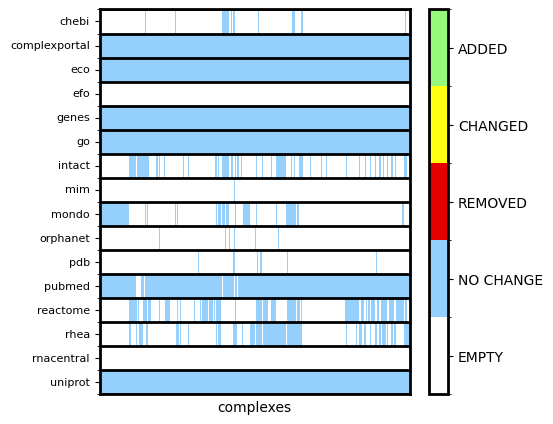

In [12]:
annotation_type = "complexes"
df_annotations = df_cplx_annotations.groupby(annotation_type, as_index=False).agg(
    lambda x: build_string(sorted(x.dropna().unique()))
)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations

#### Genes

genes: 91
uniprot: 91
complexportal: 360
eco: 5
go: 344
rnacentral: 0
chebi: 9
pdb: 9
intact: 87
reactome: 64
pubmed: 368
efo: 1
rhea: 77
orphanet: 5
mondo: 32
mim: 2


,genes,uniprot,complexportal,eco,go,rnacentral,chebi,pdb,intact,reactome,pubmed,efo,rhea,orphanet,mondo,mim
0,ACTB,P60709,CPX-1164;CPX-1194;CPX-1195;CPX-1196;CPX-1199;C...,ECO:0005547,GO:0140658;GO:2000045;GO:2000781;GO:2000819;GO...,<NA>,<NA>,<NA>,<NA>,<NA>,11790558;18809673;23644491;11073988;9843504;28...,<NA>,13065;45948,<NA>,MONDO:0015452;MONDO:0011053;MONDO:0004992;MOND...,<NA>
1,ATP11A,P98196,CPX-6310,ECO:0000353,GO:0005524;GO:0016887;GO:1990531;GO:0140346;GO...,<NA>,<NA>,<NA>,EBI-26444585,<NA>,27458383;26567335;20961850;30509129;25315773,<NA>,38567,<NA>,<NA>,<NA>
2,ATP11B,Q9Y2G3,CPX-6311,ECO:0000353,GO:0005524;GO:0016887;GO:1990531;GO:0031901;GO...,<NA>,<NA>,<NA>,EBI-26444292,<NA>,27458383;26567335;20961850;30509129;25315773;3...,<NA>,38567,<NA>,<NA>,<NA>
3,ATP11C,Q8NB49,CPX-6312,ECO:0000353,GO:0005524;GO:0016887;GO:1990531;GO:0140346;GO...,<NA>,<NA>,<NA>,EBI-25508137,<NA>,27458383;26567335;20961850;30509129;25315773;2...,<NA>,38567,<NA>,<NA>,<NA>
4,ATP1A1,P05023,CPX-125;CPX-8009;CPX-8141;CPX-8142;CPX-8143;CP...,ECO:0000353;ECO:0005610;ECO:0005546,GO:0006883;GO:0005890;GO:0005391;GO:0005524;GO...,<NA>,<NA>,<NA>,EBI-46435129;EBI-46435122;EBI-46435113,R-HSA-936770,35803952;18075585;25772291;19542013;36926029;2...,<NA>,18353,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,STK11,Q15831,CPX-2431;CPX-2845;CPX-2868;CPX-2869,ECO:0005546;ECO:0000353,GO:0004674;GO:0005737;GO:1902554;GO:0005737;GO...,<NA>,<NA>,<NA>,EBI-16181998,R-HSA-380967,19892943,<NA>,17989;46608,<NA>,MONDO:0008280,<NA>
87,TMEM30A,Q9NV96,CPX-6282;CPX-6285;CPX-6301;CPX-6302;CPX-6304;C...,ECO:0000353;ECO:0005546,GO:0140345;GO:0005524;GO:0016887;GO:1990531;GO...,<NA>,<NA>,<NA>,EBI-26441578;EBI-25507980;EBI-9539361;EBI-9527...,<NA>,26567335;30509129;27458383;20961850;25315773;2...,<NA>,38567,orphanet:1766,MONDO:0008892;MONDO:0009469,<NA>
88,UBAC1,Q9BSL1,CPX-7801,ECO:0000353,GO:0019941;GO:0051726;GO:0000151;GO:0061630;GO...,<NA>,<NA>,<NA>,EBI-1061423,<NA>,16227581,<NA>,<NA>,<NA>,<NA>,<NA>
89,VCP,P55072,CPX-137;CPX-262;CPX-8095;CPX-8096;CPX-8101;CPX...,ECO:0000353;ECO:0005547,GO:0032553;GO:0034098;GO:0030970;GO:0031593;GO...,<NA>,<NA>,3ebb,EBI-7931325;EBI-15930651;EBI-15930556;EBI-2011...,R-HSA-5654992;R-HSA-9755500,17202270;10811609;22232657;12847084;11740563;2...,<NA>,13065;33712450,<NA>,<NA>,<NA>


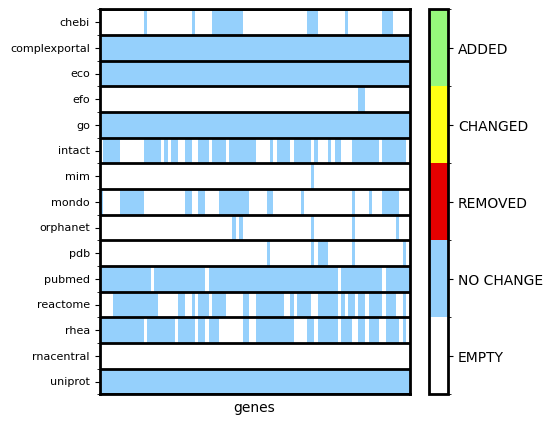

In [13]:
annotation_type = "genes"
df_annotations = df_gene_annotations.groupby(annotation_type, as_index=False).agg(
    lambda x: build_string(list(x.dropna().unique()))
)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations